### **Luxury Travel Intelligent Segmentation applying Multiple Clustering Algorithms**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)

### Data preparation

#### Data collection

In [3]:
df_guest = pd.read_excel('pimContact.xlsx')
df_booking = pd.read_excel('vwBookingCentre.xlsx')

#### Data observation: 'df_guest' & 'df_booking'

##### Head

In [ ]:
df_guest.head(5)

In [ ]:
df_booking.head(5)

##### Information

In [ ]:
df_guest.info()

In [ ]:
df_booking.info()

##### Missing values

In [ ]:
df_guest.isnull().sum()

In [ ]:
df_booking.isnull().sum()

##### Unique values

In [ ]:
for c in df_guest.columns:
    print(c)
    print(df_guest[c].unique())
    print('')

In [ ]:
for c in df_booking.columns:
    print(c)
    print(df_booking[c].unique())
    print('')

#### Data cleaning: 'df_guest'

##### 'SegmentTitle' & 'LoyaltyClub' & 'BusinessUnitName' & 'Country'

In [4]:
df_guest['SegmentTitle'] = df_guest['SegmentTitle'].fillna('Unknown')
df_guest['BusinessUnitName'] = df_guest['BusinessUnitName'].fillna('Unknown')
df_guest['Country'] = df_guest['Country'].fillna('Unknown')
df_guest['LoyaltyClub'] = df_guest['LoyaltyClub'].fillna('NoLoyaltyClub')

#### Data cleaning: 'df_booking'

##### 'Nights'

In [5]:
df_booking['Nights'] = df_booking['Nights'].apply(lambda x: abs(x) if not isinstance(x, str) else x)

##### 'BookType'

In [6]:
booktype_dict = {'Fam': 'Family or friends'}
df_booking['BookType'] = df_booking['BookType'].replace(booktype_dict)

In [7]:
businessunit_dict = {'Scott Dunn Hong Kong': 'ScottDunn Hong Kong', 'CH-Hong Kong': 'ScottDunn Hong Kong',
                     'Scott Dunn China': 'ScottDunn China', 'Scott Dunn Dubai': 'ScottDunn Dubai',
                     'CH-Singapore': 'ScottDunn Singapore'}

df_booking['BusinessUnit'] = df_booking['BusinessUnit'].replace(businessunit_dict)

##### 'Date'

In [8]:
df_booking_2 = df_booking.copy()

In [9]:
df_booking['EnquiryDate'] = df_booking['EnquiryDate'].dt.date
df_booking['QuoteDate'] = df_booking['QuoteDate'].dt.date
df_booking['BookDate'] = df_booking['BookDate'].dt.date

df_booking['BookDate'] = pd.to_datetime(df_booking['BookDate'], errors = 'coerce')
df_booking['EnquiryDate'] = pd.to_datetime(df_booking['EnquiryDate'], errors = 'coerce')
df_booking['QuoteDate'] = pd.to_datetime(df_booking['QuoteDate'], errors = 'coerce')

##### 'CommercialValueGBP'

In [10]:
df_booking['CommercialValueGBP'] = df_booking['CommercialValueGBP'].fillna(0)

#### Data merging: 'df_gb' (guests with booking records)

In [11]:
df_gb = pd.merge(df_guest, df_booking, on = 'ContactId')

#### Data cleaning: 'df_gb'

##### Missing value observation

In [ ]:
df_gb.isnull().sum()

: 

##### Unique value observation

In [13]:
for c in df_gb.columns:
    print(c)
    print(df_gb[c].unique())
    print('')

ContactId
[ 268844  268879  268902 ... 1018479 1018480 1018481]

Enabled
[ True]

Country
['United Kingdom' 'Switzerland' 'Eire' 'Hong Kong'
 'United States of America' 'Poland' 'Brazil' 'Italy'
 'United Arab Emirates' 'Australia' 'France' 'Portugal' 'Belgium'
 'South Africa' 'Lebanon' 'Singapore' 'Netherlands' 'Luxembourg' 'Canada'
 'Finland' 'Germany' 'Denmark' 'Swaziland' 'Unknown' 'Russia' 'Qatar'
 'Japan' 'Iceland' 'Bahrain' 'Nigeria' 'Spain' 'Jordan' 'Ukraine' 'Oman'
 'Tanzania' 'Greece' 'Sweden' 'Pakistan' 'Kazakhstan' 'Israel' 'Romania'
 'Malaysia' 'Monaco' 'Norway' 'Lithuania' 'Argentina' 'Bermuda'
 'New Zealand' 'Sudan' 'Thailand' 'China' 'Zambia' 'Saudi Arabia'
 'Mauritius' 'Croatia' 'Malta' 'Azerbaijan' 'Cyprus' 'Kenya' 'Turkey'
 'Mexico' 'Czech Republic' 'Ghana' 'Austria' 'Bulgaria' 'Gabon' 'Egypt'
 'Gibraltar' 'Georgia' 'Angola' 'Zimbabwe' 'India' 'Guatemala' 'Venezuela'
 'Slovakia' 'Cayman Islands' 'Slovenia' 'Serbia' 'Kuwait' 'Puerto Rico'
 'Indonesia' 'Nepal' 'Banglade

#### Feature engineering

##### Recency

In [14]:
later_date = df_gb[['BookDate', 'EnquiryDate', 'QuoteDate']].max(axis = 1)
df_gb['LaterDate'] = later_date

In [15]:
latest_date = df_gb.groupby('ContactId')['LaterDate'].max().reset_index()

In [16]:
df_guest_train = df_guest.copy()
df_guest_train = pd.merge(df_guest_train, latest_date, on = ['ContactId'], how = 'outer')
df_guest_train.rename(columns = {'LaterDate': 'LatestDate'}, inplace = True)

In [17]:
max_date = df_guest_train['LatestDate'].max()
df_guest_train['Days'] = df_guest_train['LatestDate'].apply(lambda x: (max_date - x).days if pd.notnull(x) else None)

##### Frequency

In [18]:
enquiry_n = df_booking['EnquiryDate'].notnull().groupby(df_booking['ContactId']).sum()
quote_n = df_booking['QuoteDate'].notnull().groupby(df_booking['ContactId']).sum()
book_n = df_booking['BookDate'].notnull().groupby(df_booking['ContactId']).sum()

In [19]:
df_guest_train = pd.merge(df_guest_train, enquiry_n, on = 'ContactId', how = 'outer')
df_guest_train = pd.merge(df_guest_train, quote_n, on = 'ContactId', how = 'outer')
df_guest_train = pd.merge(df_guest_train, book_n, on = 'ContactId', how = 'outer')

In [20]:
df_guest_train.rename({'EnquiryDate': 'EnquiryN', 'QuoteDate': 'QuoteN', 'BookDate': 'BookN'}, axis = 1, inplace = True)

##### Monetary

In [21]:
CommercialValue_sum = df_gb.groupby('ContactId')['CommercialValueGBP'].sum()
df_guest_train = pd.merge(df_guest_train, CommercialValue_sum, on = 'ContactId', how = 'outer')

##### Guest with booking

In [22]:
df_guest_train['GuestWithBooking'] = np.where(df_guest_train[['Days', 'QuoteN', 'EnquiryN', 'BookN', 'CommercialValueGBP']].notnull().any(axis = 1), 1, 0)

### Data exploration

#### 'df_guest_train'

In [ ]:
df_guest_train.head()

##### 'GuestWithBooking'

In [360]:
Counts_GWB = df_guest_train['GuestWithBooking'].value_counts(normalize = True).sort_values(ascending = False).mul(100).nlargest(2)

##### 'Country'

In [259]:
country_percentage = df_guest_train['Country'].value_counts(normalize = True).sort_values(ascending = False).mul(100).nlargest(5).round(3)
country_percentage = pd.DataFrame(country_percentage)

In [260]:
country_percentage.T

Country,Unknown,United States of America,United Kingdom,Singapore,Hong Kong
proportion,32.768,31.061,28.653,3.176,0.868


##### 'BusinessUnitName'

In [261]:
BUN_percentage = df_guest_train['BusinessUnitName'].value_counts(normalize = True).sort_values(ascending = False).mul(100).round(3).nlargest(5)
BUN_percentage = pd.DataFrame(BUN_percentage)

In [262]:
BUN_percentage.T

BusinessUnitName,Unknown,ScottDunn USA,ScottDunn UK,ScottDunn Singapore
proportion,32.768,31.454,30.473,5.305


##### 'SegmentTitle'

In [255]:
ST_percentage = df_guest_train['SegmentTitle'].value_counts(normalize = True).sort_values(ascending = False).mul(100).round(3).nlargest(6)
ST_percentage = pd.DataFrame(ST_percentage)

In [256]:
ST_percentage.T

SegmentTitle,Subscribers,Unknown,Enquirers,Quoters,Bookers,Repeaters
proportion,47.075,19.014,14.666,12.295,4.04,2.636


##### 'LoyaltyClub'

In [257]:
LC_percentage = df_guest_train['LoyaltyClub'].value_counts(normalize = True).sort_values(ascending = False).mul(100).round(3).nlargest(6)
LC_percentage = pd.DataFrame(LC_percentage)

In [258]:
LC_percentage.T

LoyaltyClub,NoLoyaltyClub,Guest Loyalty,SDP Prospect,Guest Loyalty Plus,SDP,Pinnacle
proportion,98.099,1.522,0.168,0.108,0.066,0.025


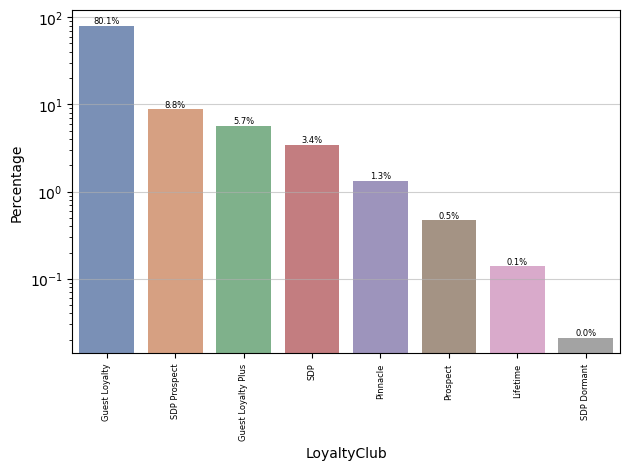

In [308]:
LC_percentage = df_guest[df_guest['LoyaltyClub'] != 'NoLoyaltyClub']['LoyaltyClub'].value_counts(normalize = True).sort_values(ascending = False).mul(100).round(3).nlargest(8)

plt.grid(axis = 'y', linestyle = '-', alpha = 0.6)
ax = sns.barplot(data = df_guest[df_guest['LoyaltyClub'] != 'NoLoyaltyClub'], x = LC_percentage.index, y = LC_percentage.values, palette = 'deep', alpha = 0.8, order = LC_percentage.index)

for (percentage, p) in (zip(LC_percentage.values, ax.patches)):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y, f'{percentage:.1f}%', ha = 'center', va = 'bottom', fontsize = 6)

plt.xlabel('LoyaltyClub')
plt.ylabel('Percentage')
plt.xticks(fontsize = 6, rotation = 90)
plt.yscale('log')
plt.tight_layout()
plt.show()

##### 'RecordStatus'

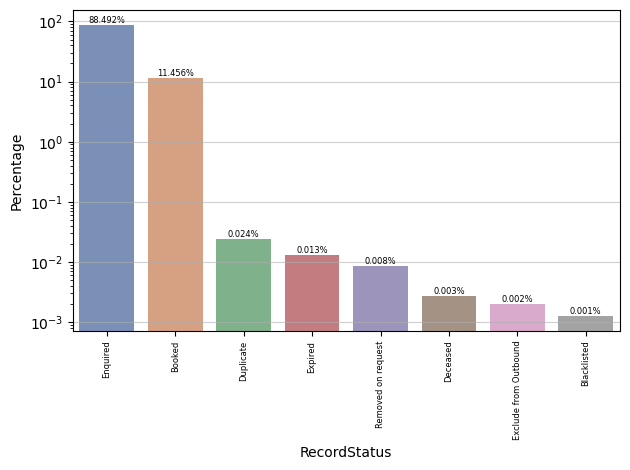

In [426]:
RS_percentage = df_guest['RecordStatus'].value_counts(normalize = True).sort_values(ascending = False).mul(100).nlargest(8)

plt.grid(axis = 'y', linestyle = '-', alpha = 0.6)
ax = sns.barplot(data = df_guest, x = RS_percentage.index, y = RS_percentage.values, palette = 'deep', alpha = 0.8, order = RS_percentage.index)

for (percentage, p) in (zip(RS_percentage.values, ax.patches)):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y, f'{percentage:.3f}%', ha = 'center', va = 'bottom', fontsize = 6)

plt.xlabel('RecordStatus')
plt.ylabel('Percentage')
plt.xticks(fontsize = 6, rotation = 90)
plt.yscale('log')
plt.tight_layout()
plt.show()

#### 'df_booking'

##### Percentage of enquriy coverting to booking

In [ ]:
count_book_or_not = df_booking['BookDate'].isnull().value_counts()

plt.figure(figsize = (6, 6))
plt.pie(count_book_or_not, labels = ['Not Converted', 'Converted'], autopct = '%1.1f%%', startangle = 140, colors = sns.color_palette('deep'), textprops = {'fontsize': 6}, wedgeprops = {'alpha':0.8})
plt.show()

##### 'EnquiryDate'

In [ ]:
plt.figure(figsize = (6, 6))
sns.displot(df_booking['EnquiryDate'], kind = 'kde', color = sns.color_palette('deep')[0], fill = True)
plt.grid(axis = 'y', linestyle = '-', alpha = 0.6)
plt.xticks(rotation = 90)
plt.show()

##### 'MetaGroupName'

In [ ]:
MGN_percentage = df_booking['MetaGroupName'].value_counts(normalize = True).sort_values(ascending = False).mul(100).round(3).nlargest(10)

plt.grid(axis = 'y', linestyle = '-', alpha = 0.6)
ax = sns.barplot(data = df_booking, x = MGN_percentage.index, y = MGN_percentage.values, palette = 'deep', alpha = 0.8, order = MGN_percentage.index)

for (percentage, p) in (zip(MGN_percentage.values, ax.patches)):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y, f'{percentage:.1f}%', ha = 'center', va = 'bottom', fontsize = 6)

plt.xlabel('MetaGroupName')
plt.ylabel('Percentage')
plt.xticks(fontsize = 6, rotation = 90)
plt.tight_layout()
plt.show()

##### 'Adults' & 'Child' & 'Infant' & 'Nights'

In [364]:
df_booking[['Adults', 'Child', 'Infant', 'Nights']].describe().round(3)

,Adults,Child,Infant,Nights
count,655007.000,655007.000,655007.000,654983.000
mean,2.861,0.805,0.105,9.435
std,2.267,1.260,0.351,40.437
min,0.000,0.000,0.000,0.000
25%,2.000,0.000,0.000,7.000
50%,2.000,0.000,0.000,8.000
75%,3.000,2.000,0.000,12.000
max,310.000,100.000,37.000,11729.000


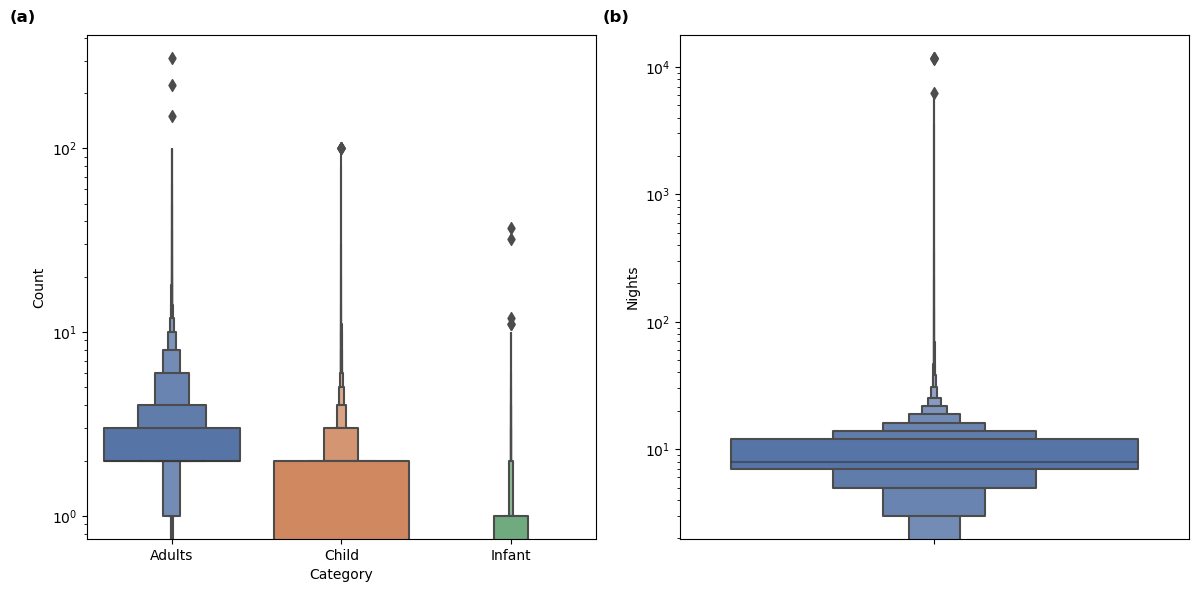

In [362]:
df_people_long = pd.melt(df_booking, value_vars = ['Adults', 'Child', 'Infant'], var_name = 'Category', value_name = 'Count')
notes = ['(a)', '(b)']

fig, axes = plt.subplots(1, 2, figsize = (12, 6))

sns.boxenplot(data = df_people_long, x = 'Category', y = 'Count', palette = 'deep', saturation = 0.8, ax = axes[0])
sns.boxenplot(data = df_booking, y = 'Nights',palette = 'deep', saturation = 0.8, ax = axes[1])
axes[0].set_yscale('log')
axes[0].text(-0.1, 1.05, notes[0], transform = axes[0].transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
axes[1].text(-0.1, 1.05, notes[1], transform = axes[1].transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

#### RFM relevant variables

##### Descriptive statistics

In [428]:
df_guest_train_description = df_guest_train.drop(['ContactId', 'LatestDate', 'GuestWithBooking'], axis = 1).describe().round(2)
df_guest_train_description

,Days,EnquiryN,QuoteN,BookN,CommercialValueGBP
count,173850.00,175031.00,175031.00,175031.00,173850.00
mean,2071.11,3.74,2.77,0.52,28158.04
std,1345.03,135.19,107.41,18.34,198739.10
min,0.00,1.00,0.00,0.00,-99672.78
25%,826.00,1.00,0.00,0.00,0.00
50%,2066.00,1.00,1.00,0.00,0.00
75%,3101.00,3.00,2.00,0.00,16330.00
max,8945.00,56351.00,44714.00,7633.00,53787029.76


##### 'EnquiryN' & 'QuoteN' & 'BookN'

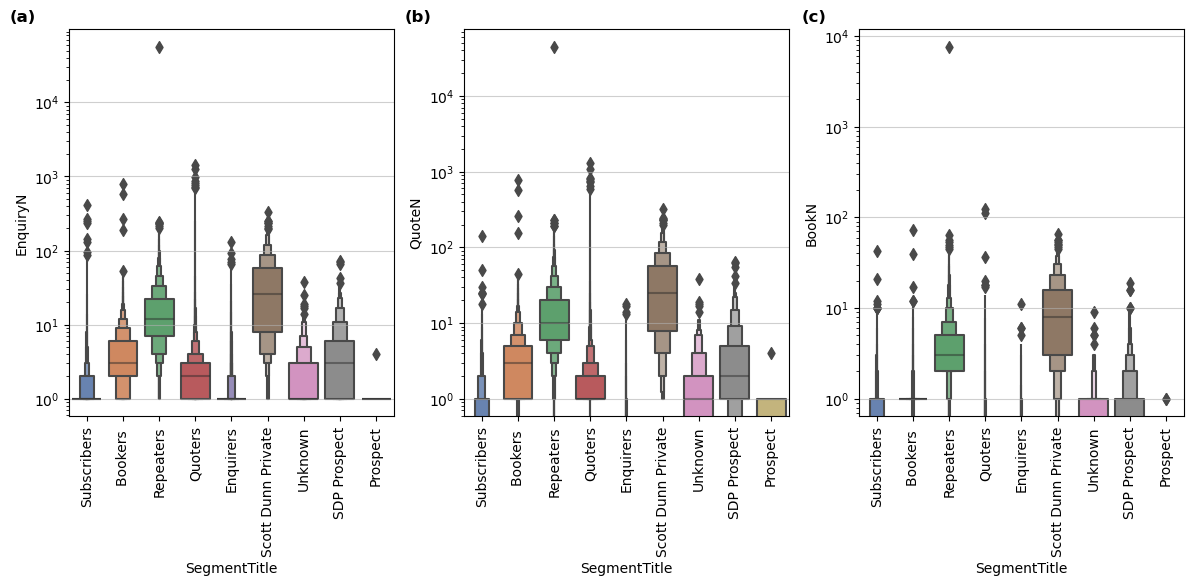

In [396]:
fig, axes = plt.subplots(1, 3, figsize = (12, 6))
notes = ['(a)', '(b)', '(c)']

i = 0
for n in ['EnquiryN', 'QuoteN', 'BookN']:
    sns.boxenplot(data = df_guest_train, x = 'SegmentTitle', y = n, palette = 'deep', saturation = 0.8, ax = axes[i])
    axes[i].grid(axis = 'y', linestyle = '-', alpha = 0.6)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 90)
    axes[i].set_yscale('log')
    axes[i].text(-0.1, 1.05, notes[i], transform = axes[i].transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
    i += 1

plt.tight_layout()
plt.show()

##### 'Days'

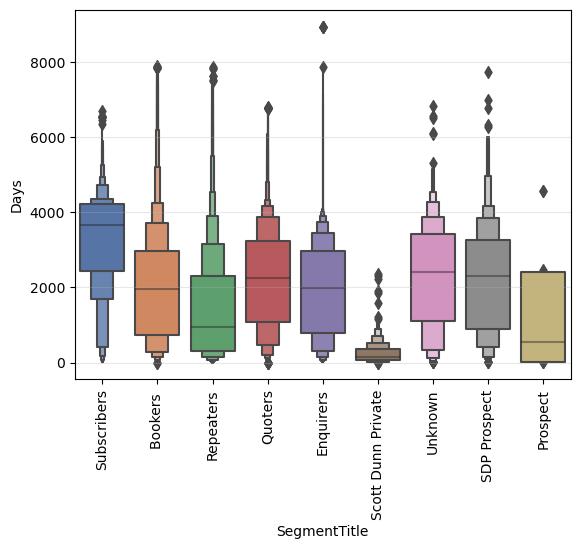

In [401]:
plt.grid(axis = 'y', linestyle = '-', alpha = 0.3)
sns.boxenplot(data = df_guest_train, y = 'Days', x = 'SegmentTitle', palette = 'deep', saturation = 0.8)
plt.xticks(rotation = 90)
plt.show()

##### 'CommercialValueGBP'

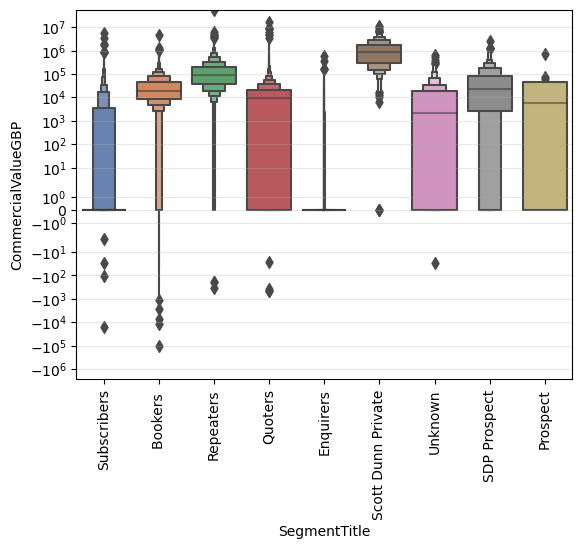

In [400]:
plt.grid(axis = 'y', linestyle = '-', alpha = 0.3)
sns.boxenplot(data = df_guest_train, y = 'CommercialValueGBP', x = 'SegmentTitle', palette = 'deep', saturation = 0.8)
plt.xticks(rotation = 90)
plt.yscale('symlog')
plt.show()

#### Outlier detection

In [23]:
df_guest_rfm = df_guest_train[df_guest_train['GuestWithBooking'] == 1][['ContactId', 'Days', 'EnquiryN', 'QuoteN', 'BookN', 'CommercialValueGBP']]

In [24]:
df_guest_rfm.isnull().sum()

ContactId                0
Days                  1181
EnquiryN                 0
QuoteN                   0
BookN                    0
CommercialValueGBP    1181
dtype: int64

In [25]:
df_guest_rfm['CommercialValueGBP'].fillna(0, inplace = True)
df_guest_rfm['Days'].fillna(df_guest_rfm['Days'].max(), inplace = True)

C:\Users\Reazeng\AppData\Local\Temp\ipykernel_25164\159823270.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_guest_rfm['CommercialValueGBP'].fillna(0, inplace = True)
C:\Users\Reazeng\AppData\Local\Temp\ipykernel_25164\159823270.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [26]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators = 100, contamination = 0.1, random_state = 30)

X_IsoForest = df_guest_rfm[['Days', 'EnquiryN', 'QuoteN', 'BookN', 'CommercialValueGBP']]
iso_forest.fit(X_IsoForest)
predictions_outlier = iso_forest.predict(X_IsoForest)

df_guest_rfm_outlier = df_guest_rfm.copy()
df_guest_rfm_outlier['Outlier'] = predictions_outlier

##### Comparison of outliers and non-outliers

'EnquiryN', 'QuoteN', 'BookN'

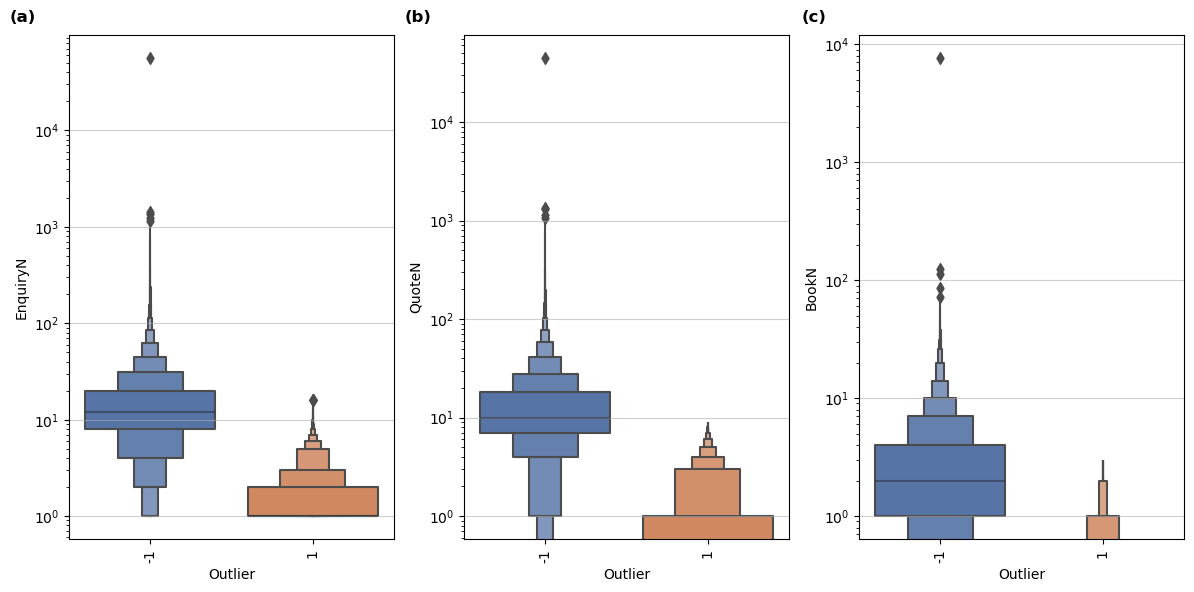

In [796]:
fig, axes = plt.subplots(1, 3, figsize = (12, 6))
notes = ['(a)', '(b)', '(c)']

i = 0
for n in ['EnquiryN', 'QuoteN', 'BookN']:
    sns.boxenplot(data = df_guest_rfm_outlier, x = 'Outlier', y = n, palette = 'deep', saturation = 0.8, ax = axes[i])
    axes[i].grid(axis = 'y', linestyle = '-', alpha = 0.6)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 90)
    axes[i].set_yscale('log')
    axes[i].text(-0.1, 1.05, notes[i], transform = axes[i].transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')
    i += 1

plt.tight_layout()
plt.show()

'Days'

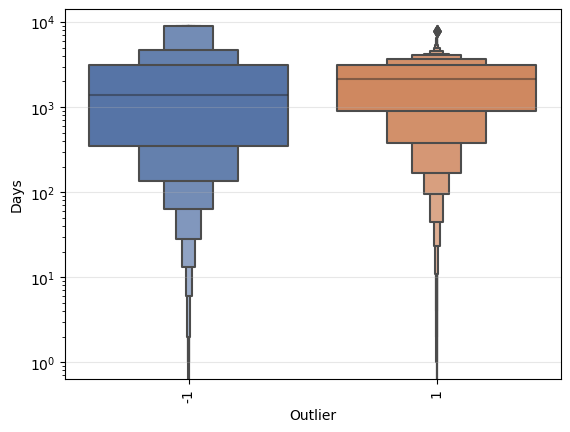

In [797]:
plt.grid(axis = 'y', linestyle = '-', alpha = 0.3)
sns.boxenplot(data = df_guest_rfm_outlier, y = 'Days', x = 'Outlier', palette = 'deep', saturation = 0.8)
plt.xticks(rotation = 90)
plt.yscale('log')
plt.show()

'CommercialValueGBP'

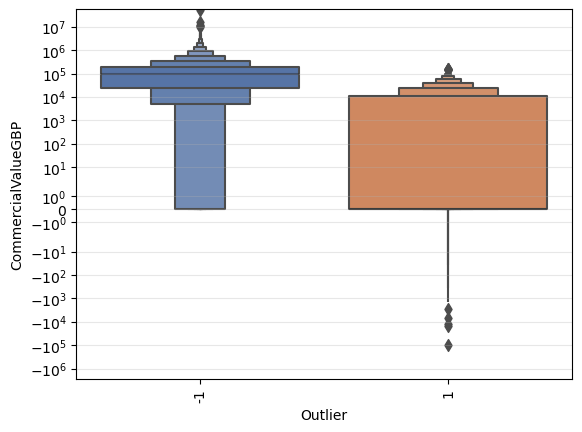

In [798]:
plt.grid(axis = 'y', linestyle = '-', alpha = 0.3)
sns.boxenplot(data = df_guest_rfm_outlier, y = 'CommercialValueGBP', x = 'Outlier', palette = 'deep', saturation = 0.8)
plt.xticks(rotation = 90)
plt.yscale('symlog')
plt.show()

#### Principle component analysis

##### Correlation matrix

In [27]:
df_guest_rfm_corr = df_guest_rfm.drop('ContactId', axis = 1).corr().round(3)

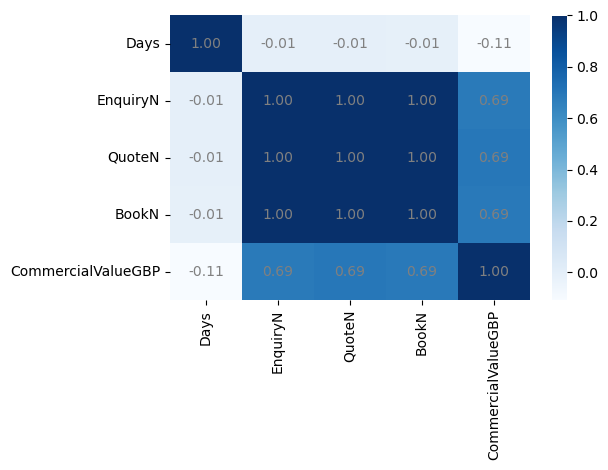

In [28]:
heatmap = sns.heatmap(df_guest_rfm_corr, cmap = 'Blues', annot = False, cbar = True)
for i in range(df_guest_rfm_corr.shape[0]):
    for j in range(df_guest_rfm_corr.shape[1]):
        text = f'{df_guest_rfm_corr.iloc[i, j]:.2f}'
        heatmap.text(j + 0.5, i + 0.5, text, ha = 'center', va = 'center', color = 'grey')
plt.tight_layout()
plt.show()

##### PCA

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_pca_input = df_guest_rfm[df_guest_rfm_outlier['Outlier'] == 1].drop('ContactId', axis = 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca_input)

pca = PCA(n_components = 5)

X_pca = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(X_pca)

##### Loading

In [30]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

loadings_df = pd.DataFrame(
    loadings, 
    columns = [f'PC{i + 1}' for i in range(loadings.shape[1])],
    index = X_pca_input.columns)

In [ ]:
heatmap = sns.heatmap(loadings_df, cmap = 'Blues', annot = False, fmt = '.3f', cbar = True)
for i in range(loadings_df.shape[0]):
    for j in range(loadings_df.shape[1]):
        text = f'{loadings_df.iloc[i, j]:.2f}'
        heatmap.text(j + 0.5, i + 0.5, text, ha = 'center', va = 'center', color = 'grey')
plt.tight_layout()
plt.show()

##### Scree plot

In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize = (8, 6))
plt.grid(axis = 'y', linestyle = '-', alpha = 0.6)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-', linewidth = 2, color = sns.color_palette('deep')[0])
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

#### Data analysis

#### Data preparation: outlier handling

#### Existing customer segmentation evaluation

In [64]:
df_guest_class = df_guest_train.copy()

##### Classify customers with a specific loyalty club

In [65]:
df_guest_class.loc[df_guest_class['SegmentTitle'] == 'Scott Dunn Private', 'Reassigned_SegmentTitle'] = 'Scott Dunn Private'
df_guest_class.loc[df_guest_class['SegmentTitle'] == 'SDP Prospect', 'Reassigned_SegmentTitle'] = 'SDP Prospect'
df_guest_class.loc[df_guest_class['SegmentTitle'] == 'Prospect', 'Reassigned_SegmentTitle'] = 'Prospect'

##### Classify customers with no loyalty club according to established rules

In [66]:
df_guest_class.loc[(df_guest_class['Reassigned_SegmentTitle'].isnull()) & (df_guest_class['BookN'] >= 1), 'Reassigned_SegmentTitle'] = 'Repeaters'
df_guest_class.loc[(df_guest_class['Reassigned_SegmentTitle'].isnull()) & (df_guest_class['BookN'] == 1), 'Reassigned_SegmentTitle'] = 'Bookers'
df_guest_class.loc[(df_guest_class['Reassigned_SegmentTitle'].isnull()) & (df_guest_class['BookN'] == 0) & (df_guest_class['QuoteN'] > 0), 'Reassigned_SegmentTitle'] = 'Quoters'
df_guest_class.loc[(df_guest_class['Reassigned_SegmentTitle'].isnull()) & (df_guest_class['BookN'] == 0) & (df_guest_class['QuoteN'] == 0) & (df_guest_class['EnquiryN'] > 0), 'Reassigned_SegmentTitle'] = 'Enquirers'
df_guest_class.loc[(df_guest_class['Reassigned_SegmentTitle'].isnull()) & (df_guest_class['GuestWithBooking'] == 0), 'Reassigned_SegmentTitle'] = 'Subscribers'


In [67]:
df_guest_class.loc[df_guest_class['SegmentTitle'] == 'nan', 'SegmentTitle'] = 'Unknown'

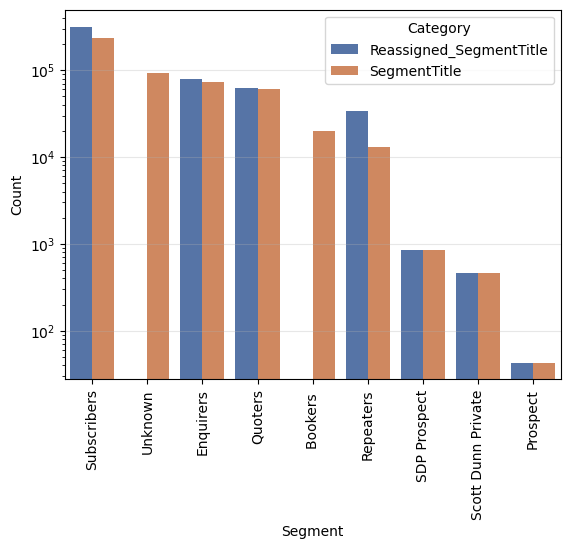

In [68]:
df_classification_long = pd.melt(df_guest_class, value_vars = ['Reassigned_SegmentTitle', 'SegmentTitle'], var_name = 'Category', value_name = 'Count')
SegmentTitle_order = df_guest_class['SegmentTitle'].value_counts(normalize = True).sort_values(ascending = False)

plt.grid(axis = 'y', linestyle = '-', alpha = 0.3)
sns.countplot(data = df_classification_long, x = 'Count', hue = 'Category', palette = 'deep', saturation = 0.8, order = SegmentTitle_order.index)
plt.xticks(rotation = 90)
plt.xlabel('Segment')
plt.ylabel('Count')
plt.yscale('log')

Classification report

In [29]:
from sklearn.metrics import classification_report

In [774]:
df_guest_class['Classification'] = df_guest_class['Classification'].astype(str)
df_guest_class['SegmentTitle'] = df_guest_class['SegmentTitle'].astype(str)

report = classification_report(df_guest_class['Classification'], df_guest_class['SegmentTitle'], output_dict = True)
report = pd.DataFrame(report)
report = report.T.round(3)

In [776]:
report

,precision,recall,f1-score,support
Bookers,0.000,0.000,0.000,0.000
Enquirers,0.998,0.911,0.953,78962.000
Prospect,1.000,1.000,1.000,43.000
Quoters,0.993,0.975,0.984,61523.000
Repeaters,0.977,0.378,0.545,33439.000
SDP Prospect,1.000,1.000,1.000,840.000
Scott Dunn Private,1.000,1.000,1.000,461.000
Subscribers,0.965,0.703,0.814,317098.000
Unknown,0.000,0.000,0.000,0.000
nan,0.000,0.000,0.000,0.000


#### Alternative customer segmentation establishment

In [35]:
X_pca_2 = X_pca.iloc[:, 0:2]

##### K-Means

In [36]:
from sklearn.cluster import KMeans

Elbow method

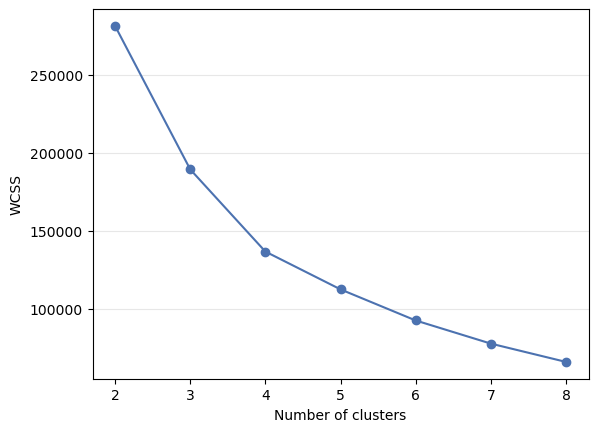

In [502]:
wcss = []
for i in range(2, 9):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 500, n_init = 10, random_state = 30)
    kmeans.fit(X_pca_2)
    wcss.append(kmeans.inertia_)
plt.grid(axis = 'y', linestyle = '-', alpha = 0.3)
plt.plot(range(2, 9), wcss, '-bo', color = sns.color_palette('deep')[0])
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Model training and predicting

In [37]:
kmeans_results = {}
for n_clusters in [3, 4, 5, 6]:
    kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 500, n_init = 10, random_state = 30, algorithm = 'elkan')
    kmeans_results[f'y_kmeans{n_clusters}'] = kmeans.fit_predict(X_pca_2)

Result exhibitting

In [ ]:
for n_clusters, y_kmeans in kmeans_results.items():
    plt.figure(figsize = (10, 6))
    for i in range(int(n_clusters[-1])):
        plt.scatter(X_pca_2.loc[y_kmeans == i, 0], X_pca_2.loc[y_kmeans == i, 1], s = 1, c = sns.color_palette('deep')[i], label = f'Cluster {i + 1}')
    plt.legend()
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

##### Agglomerative hierarchical clustering

In [155]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [156]:
X_pca_2_agg = X_pca_2.copy()

In [157]:
agg_clustering = AgglomerativeClustering(linkage = 'single', metric = 'euclidean')
y_agg = agg_clustering.fit_predict(X_pca_2_agg)

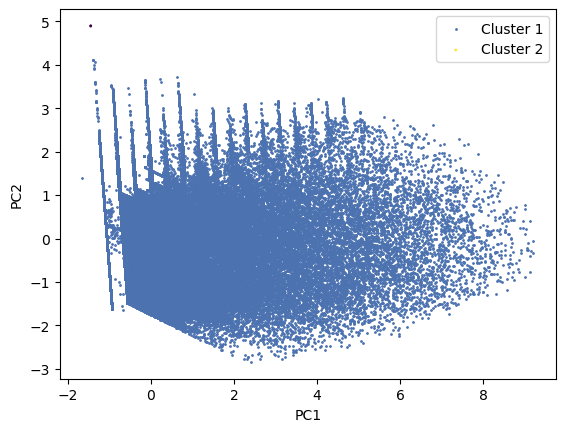

In [508]:
for i in range(len(np.unique(y_agg))):
    plt.scatter(X_pca_2.loc[y_agg == i, 0], X_pca_2.loc[y_agg == i, 1], s = 1, c = sns.color_palette('deep')[i], label = f'Cluster {i + 1}')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

##### BIRCH

In [158]:
from sklearn.cluster import Birch

In [159]:
birch_results = {}
for n_clusters in [3, 4, 5, 6]:
    birch = Birch(n_clusters = n_clusters)
    y_birch = birch.fit_predict(X_pca_2)
    birch_results[f'birch{n_clusters}'] = birch.fit_predict(X_pca_2)

In [ ]:
for n_clusters, y_birch in birch_results.items():
    plt.figure(figsize = (10, 6))
    for i in range(int(n_clusters[-1])):
        plt.scatter(X_pca_2.loc[y_birch == i, 0], X_pca_2.loc[y_birch == i, 1], s = 1, c = sns.color_palette('deep')[i], label = f'Cluster {i + 1}')
    plt.legend()
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

##### DBSCAN

In [160]:
from sklearn.cluster import DBSCAN

In [161]:
dbscan_clustering = DBSCAN()
y_dbscan = dbscan_clustering.fit_predict(X_pca_2_agg)

In [ ]:
for i in range(len(np.unique(y_dbscan))):
    plt.scatter(X_pca_2.loc[y_dbscan == i, 0], X_pca_2.loc[y_dbscan == i, 1], s = 1, c = sns.color_palette('deep')[i], label = f'Cluster {i + 1}')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

##### Mean Shift

In [162]:
from sklearn.cluster import MeanShift

In [163]:
mean_shift = MeanShift()
y_mean_shift = mean_shift.fit_predict(X_pca_2)

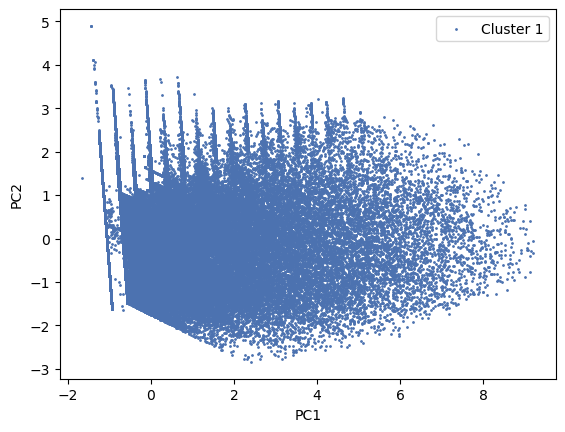

In [523]:
for i in range(len(np.unique(y_mean_shift))):
    plt.scatter(X_pca_2.loc[y_mean_shift == i, 0], X_pca_2.loc[y_mean_shift == i, 1], s = 1, c = sns.color_palette('deep')[i], label = f'Cluster {i + 1}')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### Clustering model evaluation

##### Similarity and separation

In [600]:
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [ ]:
kmeans_results.pop('y_kmeans5')
kmeans_results.pop('y_kmeans6')
birch_results.pop('birch5')
birch_results.pop('birch6')

In [553]:
dict_evaluation_scores = []
for result in [kmeans_results, birch_results]:
    for key, value in result.items():
        dict_evaluation_scores.append({'Model': key, 'Index': 'Silhouette', 'Score': metrics.silhouette_score(X_pca_2, value)})
        dict_evaluation_scores.append({'Model': key, 'Index': 'Calinski-Harabasz', 'Score': metrics.calinski_harabasz_score(X_pca_2, value)})
        dict_evaluation_scores.append({'Model': key, 'Index': 'Davies-Bouldin', 'Score': metrics.davies_bouldin_score(X_pca_2, value)})

In [622]:
scaler = MinMaxScaler()
for i in df_evaluation_scores['Index'].unique():
    df_evaluation_scores.loc[df_evaluation_scores['Index'] == i,'ScaledScore'] = scaler.fit_transform(df_evaluation_scores[df_evaluation_scores['Index'] == i]['Score'].to_numpy().reshape(-1, 1))

In [554]:
df_evaluation_scores = pd.DataFrame(dict_evaluation_scores)

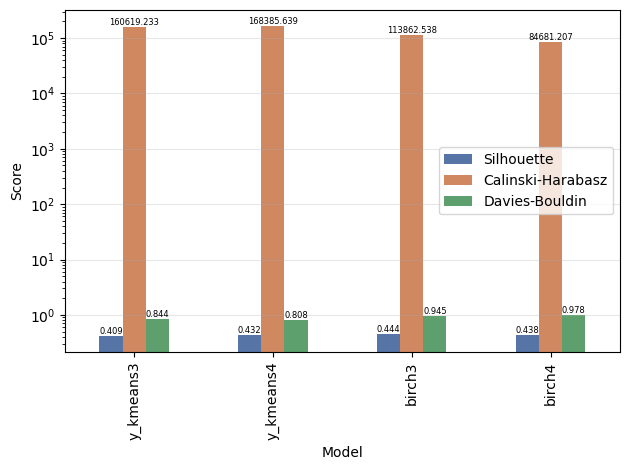

In [620]:
plt.grid(axis = 'y', alpha = 0.3)
ax = sns.barplot(data = df_evaluation_scores, x = 'Model', y = 'Score', hue = 'Index', palette = 'deep', saturation = 0.8, width = 0.5)
containers = ax.containers
for container in containers:
    ax.bar_label(container, fmt = '%.3f', label_type = 'edge', fontsize = 6)
ax.legend(loc = 'center right')
plt.xticks(rotation = 90)
plt.yscale('log')
plt.tight_layout()
plt.show()

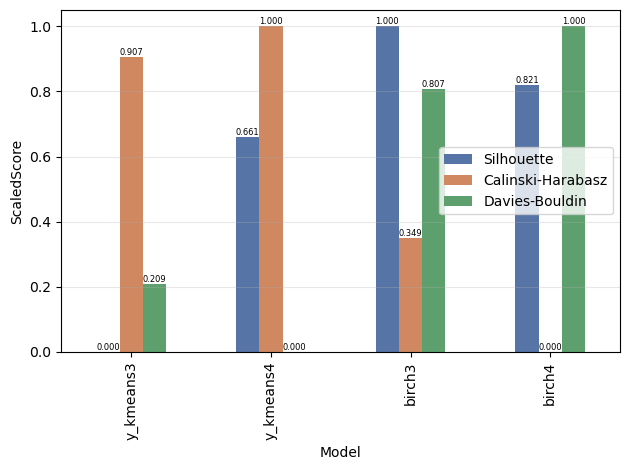

In [623]:
plt.grid(axis = 'y', alpha = 0.3)
ax = sns.barplot(data = df_evaluation_scores, x = 'Model', y = 'ScaledScore', hue = 'Index', palette = 'deep', saturation = 0.8, width = 0.5)
containers = ax.containers
for container in containers:
    ax.bar_label(container, fmt = '%.3f', label_type = 'edge', fontsize = 6)
ax.legend(loc = 'center right')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

##### Kmeans 4 demonstrates highest similarity

##### Stability

In [169]:
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split

In [629]:
def subsampling_ari(model, X, y, n_clusters, train_size):
    ari_scores = []
    
    for _ in range(5):
        X_train, _, y_train, _ = train_test_split(X, y, train_size = train_size, random_state = None)
        
        if model == 'km':
            model = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 500, n_init = 10, random_state = 30, algorithm = 'elkan')
        elif model == 'B':
            model = Birch(n_clusters = n_clusters)
        y_pred = model.fit_predict(X_train)
        ari = adjusted_rand_score(y_train, y_pred)
        ari_scores.append(ari)
        ari_scores_avg = np.mean(ari_scores)
    
    return ari_scores_avg

In [648]:
ari_scores = pd.DataFrame(columns = ['Model', 'ARI', 'SubsampleSize'])

for train_size in [0.5, 0.25]:
    for r in (kmeans_results, birch_results):
        for (key, value), n_clusters in zip(r.items(), [3, 4]):
            ari_score = pd.DataFrame([{
                'Model': key,
                'ARI': subsampling_ari('km' if r == kmeans_results else 'B', X_pca_2, value, n_clusters, train_size),
                'SubsampleSize': train_size
            }])
            ari_scores = pd.concat([ari_scores, ari_score], ignore_index = True)

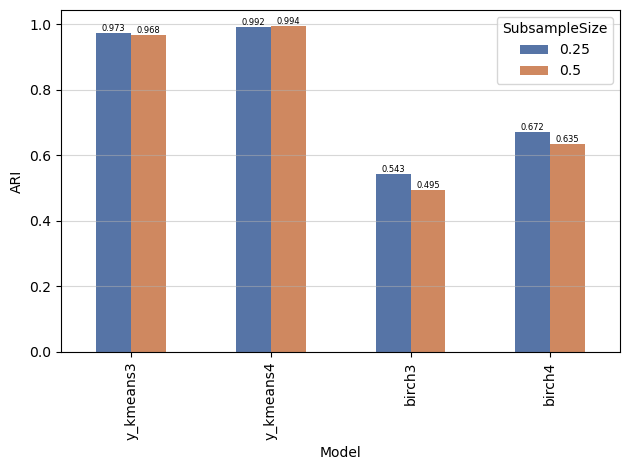

In [669]:
plt.grid(axis = 'y', alpha = 0.5)
ax = sns.barplot(data = ari_scores, x = 'Model', y = 'ARI', hue = 'SubsampleSize', palette = 'deep', saturation = 0.8, width = 0.5)
containers = ax.containers
for container in containers:
    ax.bar_label(container, fmt = '%.3f', label_type = 'edge', fontsize = 6)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

##### K-means 4 exhibit the highest stability

#### Result Analysis

##### Integrate new segments with guest data and important booking data ('Adults', 'Child', 'Infant', and 'Nights')

In [69]:
df_customer_result = df_guest_class[df_guest_class['GuestWithBooking'] == 1].copy()
df_customer_result = pd.merge(df_customer_result, df_guest_rfm_outlier[['ContactId', 'Outlier']], on = 'ContactId', how = 'left')

df_customer_result.loc[df_customer_result['Outlier'] == 1, 'Clustering_SegmentTitle'] = kmeans_results['y_kmeans4']
df_customer_result['Clustering_SegmentTitle'].fillna(4, inplace = True)
df_customer_result = pd.concat([df_customer_result, df_guest_class[df_guest_class['GuestWithBooking'] == 0]], axis = 0)
df_customer_result['Clustering_SegmentTitle'].fillna(5, inplace = True)

df_gb_result = pd.merge(df_customer_result, df_booking[['Adults', 'Child', 'Infant', 'Nights', 'ContactId', 'MetaGroupName']], on = 'ContactId', how = 'right')

##### Export data

In [58]:
df_customer_result.to_excel('df_customer_result.xlsx', index = False)

In [44]:
df_gb_result.to_excel('df_gb_result.xlsx', index = False)

##### Percentage of 'NewSegment'

In [886]:
counts_segment5 = df_guest_class['GuestWithBooking'].value_counts()[0]
counts_segment0to4 = df_customer_result['Clustering_SegmentTitle'].value_counts().values
counts_segment0to5 = np.append(counts_segment0to4, counts_segment5)

([<matplotlib.patches.Wedge at 0x203d26b5c90>,
 [Text(-1.0535522041427223, 0.3162716445494471, '0'),
  Text(-0.9788504498630758, -0.5018483802931463, '1'),
  Text(-0.5891830047409399, -0.9289044013914661, '2'),
  Text(-0.3046769954383355, -1.0569635416847019, '3'),
  Text(-0.11216419278551769, -1.094266509519858, '4'),
  Text(1.004992666138408, 0.447202125451137, '5')],
 [Text(-0.574664838623303, 0.17251180611788022, '12.9%'),
  Text(-0.5339184271980413, -0.27373548015989796, '11.4%'),
  Text(-0.32137254804051263, -0.5066751280317088, '5.5%'),
  Text(-0.16618745205727387, -0.5765255681916556, '3.6%'),
  Text(-0.061180468792100554, -0.596872641556286, '2.1%'),
  Text(0.548177817893677, 0.24392843206425652, '64.5%')])

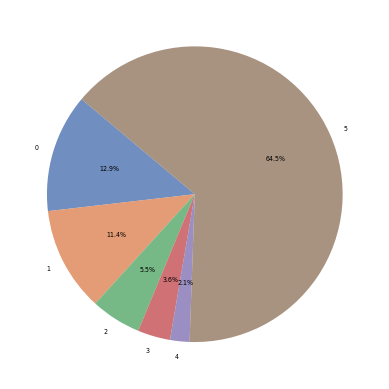

In [887]:
plt.pie(x = counts_segment0to5, labels = [i for i in range(0, 6)], autopct = '%1.1f%%', startangle = 140, colors = sns.color_palette('deep'), textprops = {'fontsize': 4.5}, wedgeprops = {'alpha':0.8})

##### Analyze RFM indicators of guests with booking data to recognize cluster features

'Days'

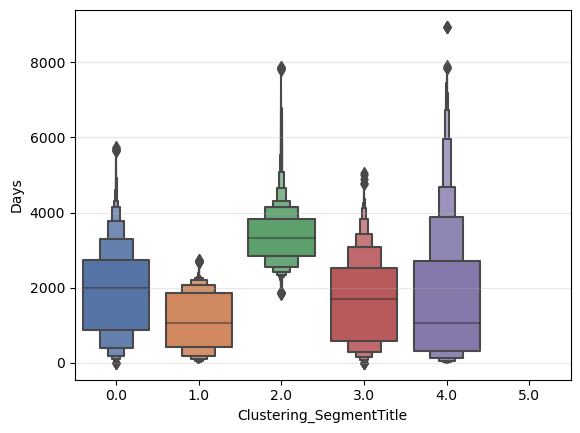

In [70]:
plt.grid(axis = 'y', linestyle = '-', alpha = 0.3)
sns.boxenplot(data = df_customer_result, y = 'Days', x = 'Clustering_SegmentTitle', palette = 'deep', saturation = 0.8)
plt.show()

'EnquiryN', 'QuoteN', 'BookN'

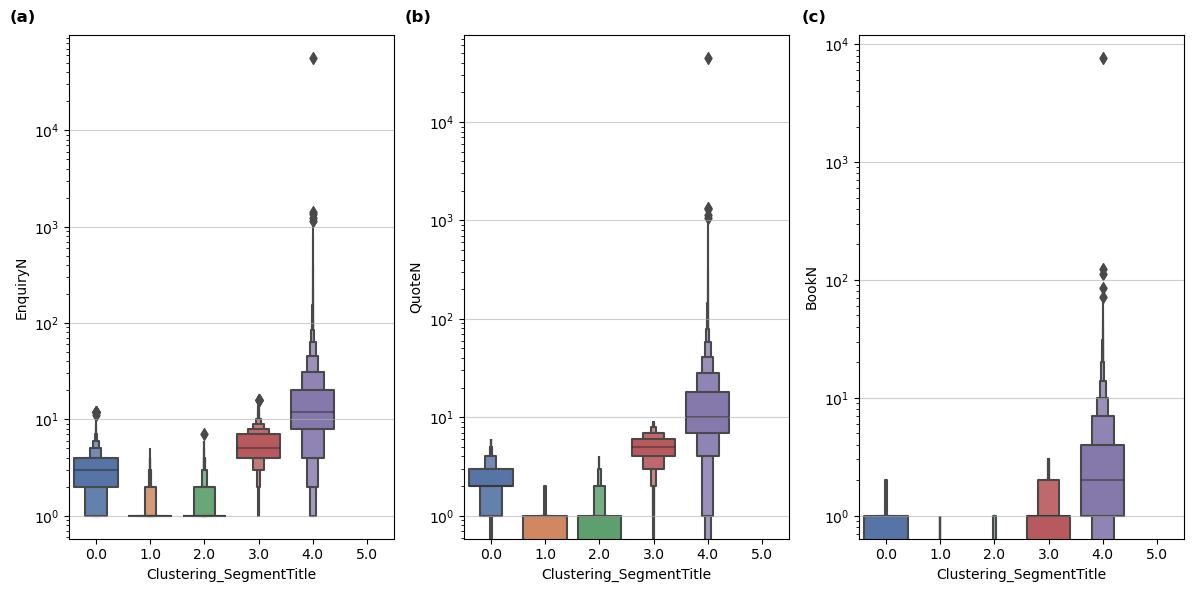

In [71]:
fig, axs = plt.subplots(1, 3, figsize = (12, 6))
axs_flat = axs.flatten()
notes = ['(a)', '(b)', '(c)']

for i, n in enumerate(['EnquiryN', 'QuoteN', 'BookN']):
    sns.boxenplot(data = df_customer_result, y = n, x = 'Clustering_SegmentTitle', palette = 'deep', saturation = 0.8, ax = axs_flat[i])
    axs_flat[i].grid(axis = 'y', linestyle = '-', alpha = 0.6)
    axs_flat[i].set_xticklabels(axs_flat[i].get_xticklabels())
    axs_flat[i].set_yscale('log')
    axs_flat[i].text(-0.1, 1.05, notes[i], transform = axs_flat[i].transAxes, fontsize = 12, fontweight = 'bold', va = 'top', ha = 'right')

plt.tight_layout()
plt.show()

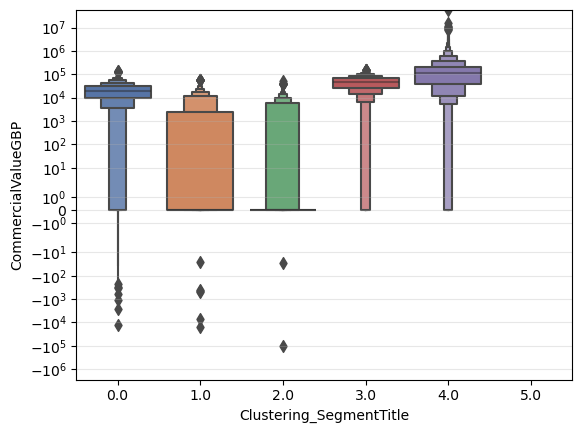

In [72]:
plt.grid(axis = 'y', linestyle = '-', alpha = 0.3)
sns.boxenplot(data = df_customer_result, y = 'CommercialValueGBP', x = 'Clustering_SegmentTitle', palette = 'deep', saturation = 0.8)
plt.yscale('symlog')
plt.show()

In [59]:
df_customer_result.drop(['ContactId', 'LatestDate', 'Outlier', 'GuestWithBooking'], axis = 1).groupby(df_customer_result['Clustering_SegmentTitle']).describe().T.round(3)

NewSegment                       0.0        1.0        2.0         3.0           4.0       5.0
Days               count   27100.000  63708.000  56247.000   10473.000  1.632200e+04       0.0
                   mean     1935.637   1136.755   3373.194    1656.507  1.721928e+03       NaN
                   std      1160.314    751.574    682.361    1133.389  1.699367e+03       NaN
                   min         0.000      0.000   1831.000       1.000  0.000000e+00       NaN
                   25%       879.000    419.000   2855.000     589.000  3.120000e+02       NaN
                   50%      2002.000   1050.000   3329.000    1685.000  1.064000e+03       NaN
                   75%      2724.000   1863.000   3832.000    2522.000  2.704000e+03       NaN
                   max      5747.000   2725.000   7868.000    5040.000  8.945000e+03       NaN
EnquiryN           count   27100.000  63708.000  56247.000   10473.000  1.750300e+04       0.0
                   mean        2.776      1.137      1.287       5.687  2.140300e+01       NaN
                   std         1.342      0.403      0.608       1.909  4.270980e+02       NaN
                   min         1.000      1.000      1.000       1.000  1.000000e+00       NaN
                   25%         2.000      1.000      1.000       4.000  8.000000e+00       NaN
                   50%         3.000      1.000      1.000       5.000  1.200000e+01       NaN
                   75%         4.000      1.000      1.000       7.000  2.000000e+01       NaN
                   max        12.000      5.000      7.000      16.000  5.635100e+04       NaN
QuoteN             count   27100.000  63708.000  56247.000   10473.000  1.750300e+04       0.0
                   mean        2.229      0.304      0.514       4.770  1.867900e+01       NaN
                   std         1.020      0.484      0.722       1.495  3.392300e+02       NaN
                   min         0.000      0.000      0.000       0.000  0.000000e+00       NaN
                   25%         2.000      0.000      0.000       4.000  7.000000e+00       NaN
                   50%         2.000      0.000      0.000       5.000  1.000000e+01       NaN
                   75%         3.000      1.000      1.000       6.000  1.800000e+01       NaN
                   max         6.000      2.000      4.000       9.000  4.471400e+04       NaN
BookN              count   27100.000  63708.000  56247.000   10473.000  1.750300e+04       0.0
                   mean        0.395      0.007      0.020       0.907  3.934000e+00       NaN
                   std         0.515      0.086      0.140       0.721  5.786500e+01       NaN
                   min         0.000      0.000      0.000       0.000  0.000000e+00       NaN
                   25%         0.000      0.000      0.000       0.000  1.000000e+00       NaN
                   50%         0.000      0.000      0.000       1.000  2.000000e+00       NaN
                   75%         1.000      0.000      0.000       1.000  4.000000e+00       NaN
                   max         2.000      1.000      1.000       3.000  7.633000e+03       NaN
CommercialValueGBP count   27100.000  63708.000  56247.000   10473.000  1.632200e+04       0.0
                   mean    22522.711   3463.832   1714.211   49478.772  2.113482e+05       NaN
                   std     18713.597   7498.819   4315.098   31373.041  6.168687e+05       NaN
                   min    -12533.760 -15381.500 -99672.781       0.000  0.000000e+00       NaN
                   25%      9239.000      0.000      0.000   25446.420  3.806364e+04       NaN
                   50%     18431.420      0.000      0.000   45567.750  1.093770e+05       NaN
                   75%     31293.642   2397.250      0.000   69268.200  2.124642e+05       NaN
                   max    141648.040  57110.000  49847.000  157312.000  5.378703e+07       NaN
NewSegment         count   27100.000  63708.000  56247.000   10473.000  1.750300e+04  317335.0
          

Cluster 0: Recency: 2, Frequency: 2, Monetary: 1  
Cluster 1: Recency: 5, Frequency: 4, Monetary: 4  
Cluster 2: Recency: 1, Frequency: 1, Monetary:2  
Cluster 3: Recency: 4, Frequency: 3, Monetary: 3  
Cluster 4 (outlier): Recency: 3, Frequency: 5, Monetary: 5  
Cluster 5 (no booking data)

#### Predicted increased value of shfiting target customer

In [ ]:
(df_customer_result[(df_customer_result['Clustering_SegmentTitle'] == 3) | (df_customer_result['Clustering_SegmentTitle'] == 4)]['CommercialValueGBP'].mean() - df_customer_result[(df_customer_result['Reassigned_SegmentTitle'] == 'Repeaters') | (df_customer_result['Reassigned_SegmentTitle'] == 'Bookers')]['CommercialValueGBP'].mean()) / df_customer_result[(df_customer_result['Reassigned_SegmentTitle'] == 'Repeaters') | (df_customer_result['Reassigned_SegmentTitle'] == 'Bookers')]['CommercialValueGBP'].mean()

0.5963943381206266

In [ ]:
(df_customer_result[(df_customer_result['Clustering_SegmentTitle'] == 3) | (df_customer_result['Clustering_SegmentTitle'] == 4)]['BookN'].mean() - df_customer_result[(df_customer_result['Reassigned_SegmentTitle'] == 'Repeaters') | (df_customer_result['Reassigned_SegmentTitle'] == 'Bookers')]['BookN'].mean()) / df_customer_result[(df_customer_result['Reassigned_SegmentTitle'] == 'Repeaters') | (df_customer_result['Reassigned_SegmentTitle'] == 'Bookers')]['BookN'].mean()

0.10201149093152315

In [ ]:
(df_customer_result[(df_customer_result['Clustering_SegmentTitle'] == 3) | (df_customer_result['Clustering_SegmentTitle'] == 4)]['Days'].mean() - df_customer_result[(df_customer_result['Reassigned_SegmentTitle'] == 'Repeaters') | (df_customer_result['Reassigned_SegmentTitle'] == 'Bookers')]['Days'].mean()) / df_customer_result[(df_customer_result['Reassigned_SegmentTitle'] == 'Repeaters') | (df_customer_result['Reassigned_SegmentTitle'] == 'Bookers')]['Days'].mean()

-0.06954421050099058

##### Clustering Profiling

Create two dataset for each segment, one includes unique 'ContactId', one includes complete booking detail, with same id possibly

In [73]:
for cluster in [0, 1, 2, 3, 4]:
    locals()[f'df_customer_result_{cluster}'] = df_customer_result.loc[df_customer_result['Clustering_SegmentTitle'] == cluster]
    locals()[f'df_customer_result_{cluster}_2'] = df_gb_result.loc[df_gb_result['Clustering_SegmentTitle'] == cluster]

df_customer_result_5 = df_guest_class[df_guest_class['GuestWithBooking'] == 0]

In [76]:
def create_cluster_profile(data, data_2, is_df_5):
    profile = pd.DataFrame()
    columns_1 = ['Country', 'BusinessUnitName', 'RecordStatus', 'SegmentTitle', 'LoyaltyClub', 'Reassigned_SegmentTitle']
    columns_2 = ['MetaGroupName', 'Adults', 'Child', 'Infant', 'Nights']
    
    for c1 in columns_1:
        group_percentage_1 = data[c1].value_counts(normalize = True).mul(100).round(3)
        group_percentage_1 = group_percentage_1.rename(f'{c1} Percentage (%)').reset_index()
        group_percentage_1 = group_percentage_1.sort_values(by = f'{c1} Percentage (%)', ascending = False).head(5)
        profile = pd.concat([profile, group_percentage_1], axis = 1, join = 'outer')
        profile = profile.fillna(0.0)
    
    if is_df_5 == False:
        for c2 in columns_2:
            group_percentage_2 = data_2[c2].value_counts(normalize = True).mul(100).round(3)
            group_percentage_2 = group_percentage_2.rename(f'{c2} Percentage (%)').reset_index()
            group_percentage_2 = group_percentage_2.sort_values(by = f'{c2} Percentage (%)', ascending = False).head(5)
            profile = pd.concat([profile, group_percentage_2], axis = 1, join = 'outer')
            profile = profile.fillna(0.0)

    profile = profile.T
    return profile

In [77]:
i = 0
for d1, d2 in zip([df_customer_result_0, df_customer_result_1, df_customer_result_2, df_customer_result_3, df_customer_result_4],
                  [df_customer_result_0_2, df_customer_result_1_2, df_customer_result_2_2, df_customer_result_3_2, df_customer_result_4_2]):
    print('')
    locals()[f'profile_{i}'] = create_cluster_profile(d1, d2, False)
    i += 1

profile_5 = create_cluster_profile(df_customer_result_5, None, True)

In [78]:
profile_0

,0,1,2,3,4
Country,United Kingdom,United States of America,Unknown,Singapore,Hong Kong
Country Percentage (%),67.568,12.092,8.055,3.114,1.258
BusinessUnitName,ScottDunn UK,ScottDunn USA,Unknown,ScottDunn Singapore,0.0
BusinessUnitName Percentage (%),71.915,12.919,8.055,7.111,0.0
RecordStatus,Enquired,Booked,Expired,Removed on request,Duplicate
RecordStatus Percentage (%),60.685,39.227,0.033,0.026,0.018
SegmentTitle,Quoters,Bookers,Subscribers,Repeaters,Enquirers
SegmentTitle Percentage (%),60.066,34.517,2.037,1.683,0.734
LoyaltyClub,NoLoyaltyClub,Guest Loyalty,SDP Prospect,Guest Loyalty Plus,SDP
LoyaltyClub Percentage (%),93.849,5.487,0.509,0.111,0.041


In [79]:
profile_1

,0,1,2,3,4
Country,United Kingdom,United States of America,Unknown,Singapore,Eire
Country Percentage (%),63.419,15.896,7.658,3.792,1.604
BusinessUnitName,ScottDunn UK,ScottDunn USA,Unknown,ScottDunn Singapore,0.0
BusinessUnitName Percentage (%),68.271,17.062,7.658,7.009,0.0
RecordStatus,Enquired,Booked,Exclude from Outbound,Blacklisted,Expired
RecordStatus Percentage (%),98.642,1.333,0.008,0.005,0.003
SegmentTitle,Enquirers,Quoters,Subscribers,Bookers,Unknown
SegmentTitle Percentage (%),69.026,27.887,2.092,0.692,0.126
LoyaltyClub,NoLoyaltyClub,Guest Loyalty,SDP Prospect,SDP,Prospect
LoyaltyClub Percentage (%),99.652,0.228,0.099,0.009,0.008


In [80]:
profile_2

,0,1,2,3,4
Country,United Kingdom,Unknown,United States of America,Australia,United Arab Emirates
Country Percentage (%),44.738,39.965,5.785,1.189,1.049
BusinessUnitName,ScottDunn UK,Unknown,ScottDunn USA,ScottDunn Singapore,0.0
BusinessUnitName Percentage (%),49.069,39.965,6.617,4.349,0.0
RecordStatus,Enquired,Booked,Expired,Removed on request,Duplicate
RecordStatus Percentage (%),97.152,2.752,0.041,0.03,0.014
SegmentTitle,Enquirers,Quoters,Subscribers,Bookers,SDP Prospect
SegmentTitle Percentage (%),49.418,37.931,10.644,1.412,0.263
LoyaltyClub,NoLoyaltyClub,SDP Prospect,Guest Loyalty,Prospect,Guest Loyalty Plus
LoyaltyClub Percentage (%),99.708,0.26,0.025,0.005,0.002


In [81]:
profile_3

,0,1,2,3,4
Country,United Kingdom,United States of America,Unknown,Singapore,Eire
Country Percentage (%),77.58,8.88,3.075,2.263,1.136
BusinessUnitName,ScottDunn UK,ScottDunn USA,ScottDunn Singapore,Unknown,0.0
BusinessUnitName Percentage (%),82.03,9.787,5.108,3.075,0.0
RecordStatus,Booked,Enquired,Removed on request,Deceased,Expired
RecordStatus Percentage (%),70.362,29.562,0.048,0.01,0.01
SegmentTitle,Bookers,Quoters,Repeaters,SDP Prospect,Subscribers
SegmentTitle Percentage (%),48.506,29.667,19.698,0.85,0.812
LoyaltyClub,NoLoyaltyClub,Guest Loyalty,SDP Prospect,Guest Loyalty Plus,SDP
LoyaltyClub Percentage (%),86.327,12.499,0.831,0.22,0.095


In [82]:
profile_4

,0,1,2,3,4
Country,United Kingdom,United States of America,Unknown,Singapore,Eire
Country Percentage (%),84.022,6.28,1.654,1.372,0.772
BusinessUnitName,ScottDunn UK,ScottDunn USA,ScottDunn Singapore,Unknown,0.0
BusinessUnitName Percentage (%),87.912,6.911,3.523,1.654,0.0
RecordStatus,Booked,Enquired,Expired,Removed on request,Duplicate
RecordStatus Percentage (%),88.468,11.501,0.018,0.006,0.006
SegmentTitle,Repeaters,Bookers,Quoters,Scott Dunn Private,Subscribers
SegmentTitle Percentage (%),62.431,20.843,11.114,2.616,1.354
LoyaltyClub,NoLoyaltyClub,Guest Loyalty,Guest Loyalty Plus,SDP,SDP Prospect
LoyaltyClub Percentage (%),71.051,22.46,2.751,1.783,1.103


In [83]:
profile_5

,0,1,2,3,4
Country,United States of America,Unknown,United Kingdom,Singapore,Hong Kong
Country Percentage (%),42.212,41.225,11.036,3.661,0.949
BusinessUnitName,ScottDunn USA,Unknown,ScottDunn UK,ScottDunn Singapore,0.0
BusinessUnitName Percentage (%),42.305,41.225,11.393,5.077,0.0
RecordStatus,Enquired,Booked,Duplicate,Expired,Removed on request
RecordStatus Percentage (%),95.076,4.879,0.034,0.007,0.001
SegmentTitle,Subscribers,Unknown,Bookers,SDP Prospect,Repeaters
SegmentTitle Percentage (%),70.287,29.32,0.244,0.063,0.045
LoyaltyClub,NoLoyaltyClub,Guest Loyalty,SDP Prospect,Prospect,Guest Loyalty Plus
LoyaltyClub Percentage (%),99.644,0.269,0.066,0.01,0.008
